# Tutorial

The first part of this notebooke is a tutorial demonstrating how to use `CNNPredictor` and a trained meta-model to make predictions.

In [25]:
%matplotlib inline

import numpy as np
import sys
import time
import seaborn as sns
from matplotlib import pyplot as plt
from kbody_predict import CNNPredictor
from kbody_input import extract_xyz
from os.path import join

One of the test example of $\textrm{C}_9\textrm{H}_7\textrm{N}$:

**Note:** 

1. The unit of the predicted energies is eV.
2. The atomic coordinates should be stored in a 3D numpy array of shape `[num_examples, num_atoms, 3]`.
3. The `species` should a list of strings and `len(species)` should be `num_atoms` but not `num_atoms * num_examples`.

In [3]:
example = {
  "coords": np.array([
    [13.64290653,      14.13624462,       5.00000000],
    [14.15947101,      10.84962323,       5.00000000],
    [14.76810787,       9.57195729,       5.00000000],
    [15.48133668,       8.52875020,       5.00000000],
    [12.43268116,      13.68893092,       5.00000000],
    [12.80400662,      11.04896203,       5.00000000],
    [10.69871088,      11.93562620,       5.00000000],
    [10.49418002,      10.46513468,       5.00000000],
    [11.80136861,       9.98973463,       5.00000000],
    [12.02985377,      12.30192209,       5.00000000],
    [13.81935751,      15.13241536,       5.00000000],
    [14.45192832,      13.52872145,       5.00000000],
    [14.86239638,      11.67891117,       5.00000000],
    [11.63193585,      14.42890524,       5.00000000],
    [ 9.87504964,      12.64680696,       5.00000000],
    [12.06052266,       8.93300535,       5.00000000],
    [14.30308267,       8.39805400,       5.00000000],
  ]).reshape((1, 17, 3)),
  "energy": -550.820680481,
  "species": [
    'N', 
    'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
    'H', 'H', 'H', 'H', 'H', 'H', 'H',
  ]
}
species = example["species"]
coords = example["coords"]

Initialize a `CNNPredictor` from a trained model. This step may take tens of seconds. Please keep the instance of `CNNPredictor` in memory.

In [4]:
model_path = join("./", "models", "C9H7Nv1.v2.DFTB", "model.ckpt-3000000")
calculator = CNNPredictor(["C", "H", "N"], model_path, many_body_k=3, max_occurs={"N": 1})

Then we can make predictions. The `CNNPredictor.predict` will return three values:

1. `y_total` is a 1D array and `y_total[i]` is the `ith` energy.
2. `y_atomic` is a 2D array and `y_atomic[i, j]` represents the energy of `jth` atom of `ith` structure.
3. `y_kbody` is a 2D array as the predicted kbody contributions.

In [5]:
y_total, y_atomic, _ = calculator.predict(species, coords)

In [6]:
y_total

array([-550.87487793], dtype=float32)

In [7]:
for i in range(len(example["species"])):
  print("Atom %2d %2s  Energy: % 12.6f eV" % (i + 1, species[i], y_atomic[0, i]))

Atom  1  N energy:   -47.405555 eV
Atom  2  C energy:   -41.397311 eV
Atom  3  C energy:   -41.856576 eV
Atom  4  C energy:   -40.554235 eV
Atom  5  C energy:   -41.748245 eV
Atom  6  C energy:   -42.072774 eV
Atom  7  C energy:   -41.773013 eV
Atom  8  C energy:   -40.863932 eV
Atom  9  C energy:   -41.821598 eV
Atom 10  C energy:   -42.106484 eV
Atom 11  H energy:   -18.514394 eV
Atom 12  H energy:   -18.324350 eV
Atom 13  H energy:   -18.525794 eV
Atom 14  H energy:   -18.578355 eV
Atom 15  H energy:   -18.480985 eV
Atom 16  H energy:   -18.479390 eV
Atom 17  H energy:   -18.371898 eV


# Analysis

The second part of this notebook shows the relation between mean absolution error (MAE) and the relative energy.

In [10]:
xyzfile = join("..", "datasets", "C9H7Nv1.xyz")
species, energies, coords, _ = extract_xyz(
  xyzfile, 
  xyz_format='grendel', 
  parse_forces=False, 
  num_examples=5000, 
  num_atoms=17
)
energies = np.atleast_1d(energies)

Extract cartesian coordinates ...
Progress:    5000  /     5000
Total time: 0.494 s



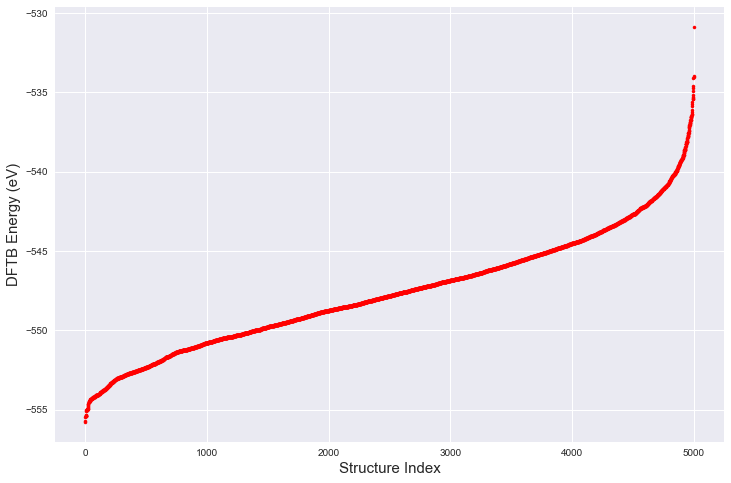

In [50]:
fig, ax = plt.subplots(1, figsize=[12, 8])
ax.plot(energies, "r.")
ax.set_xlabel("Structure Index", fontsize=15)
ax.set_ylabel("DFTB Energy (eV)", fontsize=15)
plt.show()

Calculate the accumulative mean absolute errors.

In [52]:
num_examples = 5000
step = 100
cum_mae = []
delta_energy = []
total_run = 0
total_time = 0.0
for i in range(step, num_examples + 1,step):
  tic = time.time()
  y_total, _, _ = calculator.predict(species, coords[:i])
  elapsed = time.time() - tic
  total_run += i
  total_time += elapsed
  cum_mae.append(np.mean(np.abs(energies[:i] - y_total)))
  delta_energy.append(energies[:i][-1] - energies[0])
  sys.stdout.write("\rProgress: %4d / %4d" % (i, num_examples))

print("")
print("Total predictions : %d" % total_run)
print("Total time used   : %f seconds" % total_time)
print("Average speed     : %.3f examples / second" % (total_run / total_time))

Progress: 5000 / 5000
Total predictions : 127500
Total time used   : 322.132805 seconds
Average speed     : 395.799 examples / second


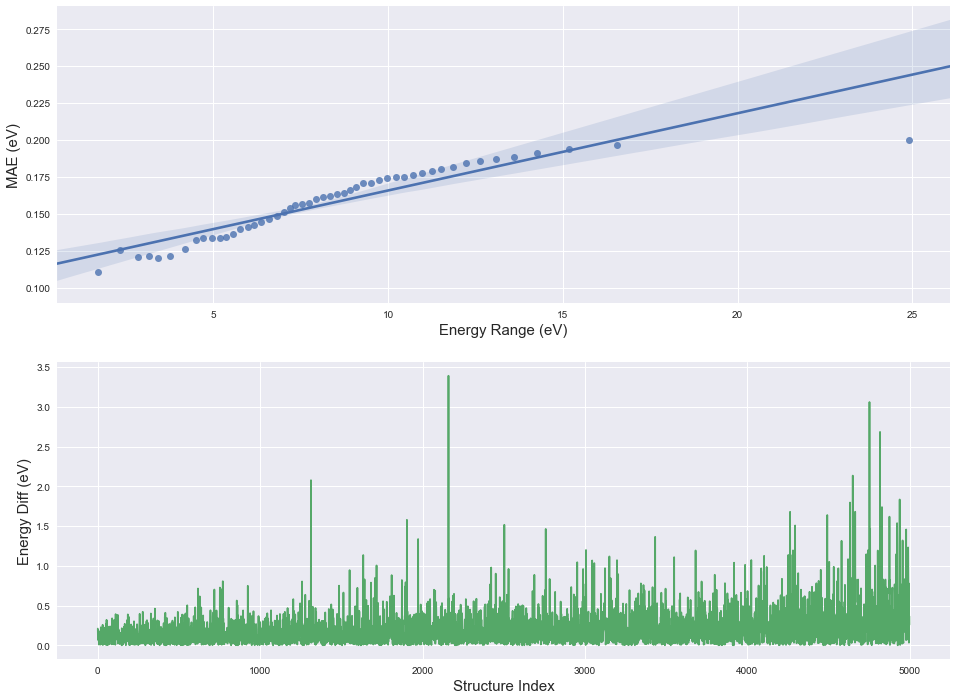

In [58]:
fig, axes = plt.subplots(2, figsize=[16, 12])

ax = axes[0]
sns.regplot(x=np.array(delta_energy), y=np.array(cum_mae), fit_reg=True, ax=ax)
ax.set_xlabel("Energy Range (eV)", fontsize=15)
ax.set_ylabel("MAE (eV)", fontsize=15)

ax = axes[1]
ax.plot(np.abs(y_total - energies))
ax.set_xlabel("Structure Index", fontsize=15)
ax.set_ylabel("Energy Diff (eV)", fontsize=15)